# Compare LC of runs

The goal is to compare LC curves of different runs.
1. Same model across different datasets.
2. Same dataset across different models.


Overall workflow:
1. LS-HPO to find the model's best HPs
2. Using HPs from LS-HPO generate LC across multiple seeds
3. Aggregate results across multiple seeds by computing median per shard
4. Fit power-law to the aggregated data

Which steps are completed:
1. LS-HPO was not properly done to anyone of the datasets. Only partial ranges have been explored.<br>
PS-HPO runs are executed using LGBM for CTRP and GDSC on theta.
2. ...

- https://www.youtube.com/watch?v=Jl-Ye38qkRc
- https://www.youtube.com/watch?v=4vryPwLtjIY

In [119]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import os
import sys
from pathlib import Path

import sklearn
import numpy as np
import pandas as pd
from glob import glob

import matplotlib
import matplotlib.pyplot as plt

# Make all python scripts available in the path
sys.path.append('../')

import pp_utils
import lrn_crv_plot
# from keras.models import load_model
%matplotlib inline

filepath = Path(os.getcwd())
print(filepath)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/vol/ml/apartin/projects/LearningCurves/notebooks


### CCLE

We didn't do HPO search for NNs.

In [103]:
# path = '/vol/ml/apartin/projects/LearningCurves/trn.ccle/split_on_none/multi_seed_LS-Best/all_seed_runs_scores.csv'
# df = pd.read_csv(path)
# df = df[ (df['metric']=='mean_absolute_error') & (df['set']=='te')].reset_index(drop=True)

### GDSC

- We did LGBM HPO search. LS-HPO and PS-HPO exhibit only a small difference. We refined the LS-HPO.
    - Consider re-running PS-HPO on theta with larger range or hyperspace. This can also provide analysis of percentage improvement over of HPO as a function of tr size.<br>
- By plotting data points across all HP runs, we notice that the larger the dataset is, the more room for improvement we can achieve with HPO.<br>
- We did NN_REG0 HPO search. All HPs except lr were within the range of the defined HPs ranges. We re-ran LC generation with LS-best HPs. The fit looks ok. Probably multi-seed run can generate better fit.<br>
- We did not run HPO with attention model, but rather used LS-best HPs from NN_REG0. Attention in that case shows worse performance.<br>
- We tried a larger network (double the size of neurons in each layer and add another layer). Most shards did not converge.<br>

In [159]:
# GDSC
maindir = filepath / '../trn.gdsc/'

# lgb_reg_dir = maindir / 'hpo_lgbm/trn.gdsc/split_on_none/gdsc.lgb_reg.GE.DD.AUC_2019-11-21_h10-m10'

lgb_reg_dir = maindir / 'split_on_none/gdsc.lgb_reg.ge.dd.auc_2019-11-25_ls_best'
nn_reg_dir = maindir / 'split_on_none/gdsc.adam.nn_reg0.ge.dd.auc_2019-11-20_ls_best_run1'
nn_reg_dlft_dir = maindir / 'split_on_none/gdsc.sgd.nn_reg0.ge.dd.auc_2019-11-20_defaults'
nn_reg_attn_ls_best_dir = maindir / 'split_on_none/gdsc.adam.nn_reg_attn.ge.dd.auc_2019-11-22'

nn_reg_hack_dir = maindir / 'split_on_none/hack_nn_reg0_ls_best'

nn_reg_mini = maindir / 'split_on_cell/gdsc.adam.nn_reg_mini.ge.dd.auc_2019-11-27'
nn_reg_ls_best = maindir / 'split_on_cell/gdsc.adam.nn_reg0.ge.dd.auc_2019-11-27'
shard_min_idx = 4 # or >1
runs   = [nn_reg_mini, nn_reg_ls_best]
labels = ['nn_reg_mini',   'nn_reg_ls_best']

# Predict AUC1
# lgb_reg_dir = maindir / 'split_on_none/gdsc.lgb_reg.ge.dd.auc_2019-11-25_ls_best'
# nn_reg_dir = maindir / 'split_on_none/gdsc.adam.nn_reg0.ge.dd.auc1_2019-11-25_defaults'
# nn_reg_attn_dir = maindir / 'split_on_none/gdsc.adam.nn_reg_attn.ge.dd.auc1_2019-11-25_defaults'

# shard_min_idx = 3 # or >1
# runs   = [lgb_reg_dir, nn_reg_dir, nn_reg_attn_dir]
# labels = ['lgb_reg',   'nn_reg',   'nn_reg_attn']

# runs   = [lgb_reg_dir, nn_reg_dir, nn_reg_dlft_dir, nn_reg_attn_ls_best_dir]
# labels = ['lgb_reg',   'nn_reg',  'nn_reg_dlft', 'nn_reg_attn_ls_best']

# shard_min_idx = 1 # or >1
# runs   = [lgb_reg_dir, nn_reg_dir]
# labels = ['lgb_reg',   'nn_reg']

# shard_min_idx = 1 # why >1 doesn't work?
# runs   = [lgb_reg_dir, nn_reg_hack_dir, nn_reg_dir]
# labels = ['lgb_reg',   'nn_reg_hack',   'nn_reg']

# shard_min_idx = 1 # why >1 doesn't work?
# runs   = [nn_reg_dir, nn_reg_dlft_dir]
# labels = ['nn_reg',  'nn_reg_dlft']

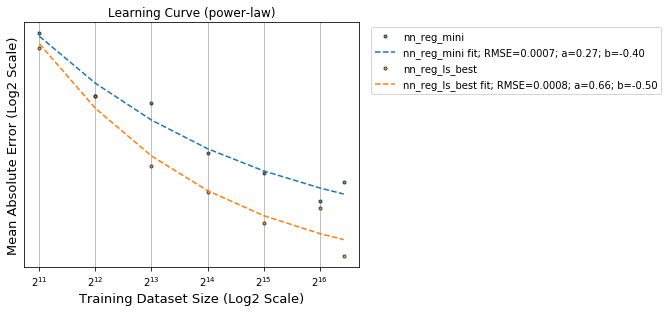

In [160]:
plot_kwargs = {'metric_name': 'mean_absolute_error', 'tr_set': 'te', 'figsize': (6, 4.5),
               # 'xtick_scale': 'linear', 'ytick_scale': 'linear',
               'xtick_scale': 'log2', 'ytick_scale': 'log2',
              }

ax = pp_utils.fit_lc_multi_runs( runs=runs, labels=labels, shard_min_idx=shard_min_idx, **plot_kwargs );

### CTRP

- We did LGBM HPO search. LS-HPO and PS-HPO exhibit only a small difference. We need to refine the LS-HPO on Lamina.<br>
- We did NN_REG0 HPO search. All HPs are at the edge of the range of the defined HP ranges: batch_size=128, lr=0.0001, dr_rate=0.3. We re-ran LC generation with LS-best HPs. The fit looks ok (but won't extrapolate). Multi-seed run may generate better fit.<br>
- We did not run HPO with attention model, but rather used LS-best HPs from NN_REG0. Attention in that case shows worse performance.<br>

In [137]:
# CTRP
maindir = filepath / '../trn.ctrp/'
lgb_reg_dir     = maindir / 'split_on_none/ctrp.lgb_reg.ge.dd.auc_2019-11-25_ls_best'
nn_reg_dir      = maindir / 'split_on_none/ctrp.adam.nn_reg0.ge.dd.auc_2019-11-22_ls_best'
nn_reg_attn_dir = maindir / 'split_on_none/ctrp.adam.nn_reg_attn.ge.dd.auc_2019-11-22'

runs   = [nn_reg_dir, nn_reg_attn_dir]
labels = ['nn_reg', 'nn_reg_attn']

# shard_min_idx = 1 # or >1
# runs   = [lgb_reg_dir, nn_reg_dir]
# labels = ['lgb_reg',   'nn_reg']

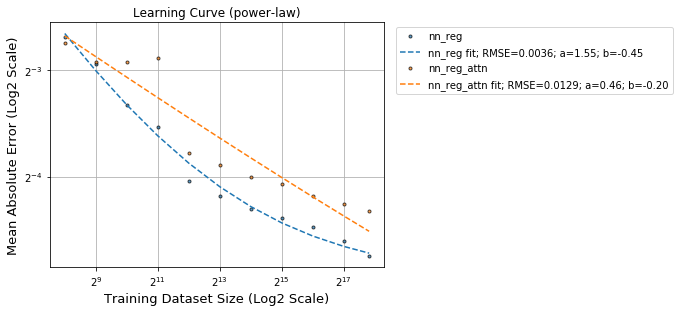

In [138]:
plot_kwargs = {'metric_name': 'mean_absolute_error', 'tr_set': 'te', 'figsize': (6, 4.5), 'xtick_scale': 'log2', 'ytick_scale': 'log2'}

pp_utils.fit_lc_multi_runs( runs=runs, labels=labels, shard_min_idx=shard_min_idx, **plot_kwargs );

## Top6

Problem: How come LGBM is comparable to LS-HPs with NN_REG0??

In [133]:
maindir = filepath / '../trn.top6/'
lgb_reg_100_dir = maindir / 'split_on_none/top6.lgb_reg.ge.dd.auc_2019-11-24_100_trees'
lgb_reg_1000_dir = maindir / 'split_on_none/top6.lgb_reg.ge.dd.auc_2019-11-24_1000_trees'
nn_reg_dir = maindir / 'split_on_none/top6.adam.nn_reg0.ge.dd.auc_2019-11-23_ls_best'
nn_reg_attn_dir = maindir / 'split_on_none/top6.adam.nn_reg_attn.cvf1.ge.dd.auc_2019-11-23'

# Predict AUC1
# nn_reg0_dir = maindir / 'split_on_none/top6.sgd.nn_reg0.ge.dd.auc_2019-11-24_defaults'
# nn_reg_attn_dir = maindir / 'split_on_none/top6.sgd.nn_reg_attn.ge.dd.auc1_2019-11-25_defaults'
# shard_min_idx = 1 # or >1
# runs   = [nn_reg0_dir, nn_reg_attn_dir, lgb_reg_dir]
# labels = ['nn_reg0',   'nn_reg_attn',   'lgb_reg']

# shard_min_idx=6
# runs   = [nn_reg_dir, nn_reg_attn_dir]
# labels = ['nn_reg',   'nn_reg_attn']

# shard_min_idx=2
# runs   = [lgb_reg_100_dir, lgb_reg_1000_dir, nn_reg_dir]
# labels = ['lgb_reg_100',   'lgb_reg_1000',   'nn_reg']

# shard_min_idx=4 # or >4
# runs   = [lgb_reg_100_dir, nn_reg_dir]
# labels = ['lgb_reg_100',   'nn_reg']

# shard_min_idx=4 # or >4
# runs   = [lgb_reg_1000_dir, nn_reg_dir]
# labels = ['lgb_reg_1000',   'nn_reg']

# shard_min_idx=5 # or >4
# runs   = [lgb_reg_1000_dir, nn_reg_dir, lgb_reg_dlft_dir]
# labels = ['lgb_reg_1000',   'nn_reg',   'lgb_reg_dlft']

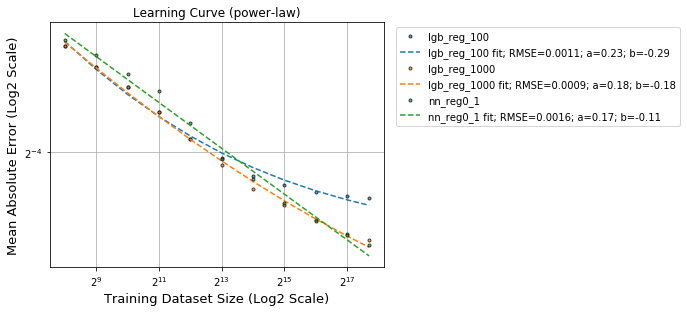

In [134]:
plot_kwargs = {'metric_name': 'mean_absolute_error', 'tr_set': 'te', 'figsize': (6, 4.5), 'xtick_scale': 'log2', 'ytick_scale': 'log2'}

pp_utils.fit_lc_multi_runs( runs=runs, labels=labels, shard_min_idx=shard_min_idx, **plot_kwargs );

## Comparing datasets

Are the LC plots follow the same trajectory for the overlapping tr_size regions? If not, what is the cause?<br>
We need to used aggregation over multiple seeds!

In [92]:
# GDSC and LGBM
gdsc_lgb_reg_dir = filepath / '../trn.gdsc/split_on_none/gdsc.lgb_reg.ge.dd.auc_2019-11-25_ls_best'
ctrp_lgb_reg_dir = filepath / '../trn.ctrp/split_on_none/ctrp.lgb_reg.ge.dd.auc_2019-11-25_ls_best'
# gdsc_nn_reg0_dir = filepath / 'trn.gdsc/split_on_none/gdsc.lgb_reg.cvf1.ge.dd.auc_2019-11-25_LS_best'

# GDSC and NN_REG0
# gdsc_nn_reg0_dir = filepath / '../trn.gdsc/split_on_none/gdsc.adam.nn_reg0.ge.dd.auc_2019-11-20_ls_best_run1'
gdsc_nn_reg0_dir = filepath / '../trn.gdsc/split_on_none/hack_nn_reg0_ls_best'
ctrp_nn_reg0_dir = filepath / '../trn.ctrp/split_on_none/ctrp.adam.nn_reg0.ge.dd.auc_2019-11-22_ls_best'


# gdsc_lgb_reg_dir = maindir / 'hpo_lgbm/trn.gdsc/split_on_none/gdsc.lgb_reg.cvf1.GE.DD.AUC_2019-11-21_h10-m10'
# nn_reg0_dir = maindir / 'split_on_none/gdsc.adam.nn_reg0.cvf1.ge.dd.auc_2019-11-20_LS_best_hps_earlystop_valmae'
# gdsc_nn_reg0_dlft_valmae_dir = maindir / 'split_on_none/gdsc.sgd.nn_reg0.cvf1.ge.dd.auc_2019-11-20_defaults_earlystop_valmae'

# CTRP

# nn_reg0_1_dir = maindir / 'split_on_none/ctrp.lgb_reg.cvf1.ge.dd.auc_2019-11-4_h16-m38'
# ctrp_nn_reg0_2_dir = maindir / 'split_on_none/ctrp.sgd.nn_reg0.cvf1.ge.dd.auc_2019-11-4_h13-m7'

# Top6
pass

# runs   = [gdsc_lgb_reg_dir, ctrp_lgb_reg_dir, gdsc_nn_reg0_dlft_valmae_dir, ctrp_nn_reg0_2_dir]
# labels = ['gdsc_lgb_reg', 'ctrp_lgb_reg', 'gdsc_nn_reg0_dlft', 'ctrp_nn_reg0_2']

# GDSC and CTRP with LGBM - good!
shard_min_idx = 1
runs   = [gdsc_lgb_reg_dir, ctrp_lgb_reg_dir]
labels = ['GDSC lgb reg',   'CTRP lgb reg']

# GDSC and CTRP with NN_REG0 - good!
shard_min_idx = 1
runs   = [gdsc_nn_reg0_dir, ctrp_nn_reg0_dir]
labels = ['GDSC nn reg0',   'CTRP nn reg0']

# GDSC and CTRP with LGBM and NN_REG0 - good!
shard_min_idx = 1
runs   = [gdsc_lgb_reg_dir, ctrp_lgb_reg_dir, gdsc_nn_reg0_dir, ctrp_nn_reg0_dir]
labels = ['GDSC lgb reg',   'CTRP lgb reg',   'GDSC nn reg0',   'CTRP nn reg0']

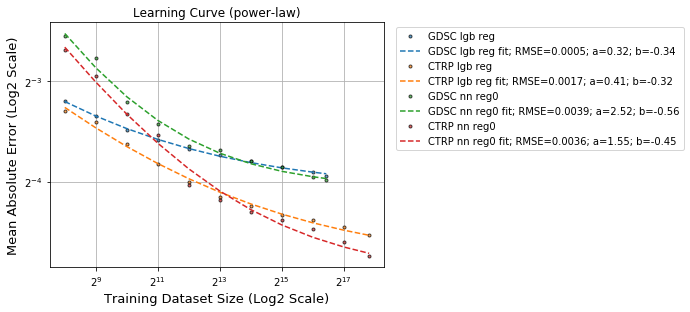

In [93]:
plot_kwargs = {'metric_name': 'mean_absolute_error', 'tr_set': 'te', 'figsize': (6, 4.5), 'xtick_scale': 'log2', 'ytick_scale': 'log2'}

pp_utils.fit_lc_multi_runs( runs=runs, labels=labels, shard_min_idx=shard_min_idx, **plot_kwargs );

# Old runs (the good results)

In [107]:
def get_xy_(path:str, metric_name:str='mean_absolute_error', tr_set:str='te', shard_min_idx:int=0, cv_folds:int=1):
    """ Extract x and y (tr size and score) for the plot.
    Args:
        tr_set : 'tr', 'vl', 'te'
    Returns:
        x : vector of tr size 
        y : vector of scores
    """
    scores = pd.read_csv( Path(path)/'lrn_crv_scores.csv' )
    df = scores[scores['metric']==metric_name].reset_index(drop=True)

    # fold_col_names = [c for c in df.columns if 'fold' in c]
    fold_col_names = [c for c in df.columns if 'f' in c]
    cols = ['tr_size'] + fold_col_names[:cv_folds]
    dd = df.loc[df['tr_set']==tr_set, cols].sort_values('tr_size').reset_index(drop=True)

    x = dd['tr_size'].values
    # y = dd.iloc[:,1:].mean(axis=1).values # mean over folds
    y = dd.iloc[:,1:].median(axis=1).values # median over folds
    x, y = x[shard_min_idx:], y[shard_min_idx:]
    return x, y

def fit_pwr_multi_runs(runs, labels, metric_name='mean_absolute_error', tr_set=False, shard_min_idx=0,
                       xtick_scale:str='log2', ytick_scale:str='log2', cv_folds=1, title=None, figsize=(6, 4.5)):
    prms = []
    for i, r in enumerate(runs):       
        x, y = get_xy_(Path(r), metric_name=metric_name, tr_set=tr_set, shard_min_idx=shard_min_idx, cv_folds=cv_folds)

        if i == 0:
            ax = None
        ax, fit_prms, rmse = lrn_crv_plot.plot_lrn_crv_power_law(x, y, plot_fit=True, metric_name=metric_name,
                                xtick_scale=xtick_scale, ytick_scale=ytick_scale,
                                xlim=None, ylim=None, title=title,
                                label=labels[i], ax=ax, figsize=figsize)

        prms.append( (labels[i], fit_prms) ) # aggregate params
    return prms

[('LGBM Reg',
  {'alpha': 12.09187263831906,
   'beta': -0.7766513628332724,
   'gamma': 0.0707256433815079}),
 ('7-layer',
  {'alpha': 1.2121806710557,
   'beta': -0.35534153457769246,
   'gamma': 0.05457020988442337}),
 ('7-layer w/ Attention',
  {'alpha': 54.78934957352949,
   'beta': -0.7105021639926878,
   'gamma': 0.05918354428738559})]

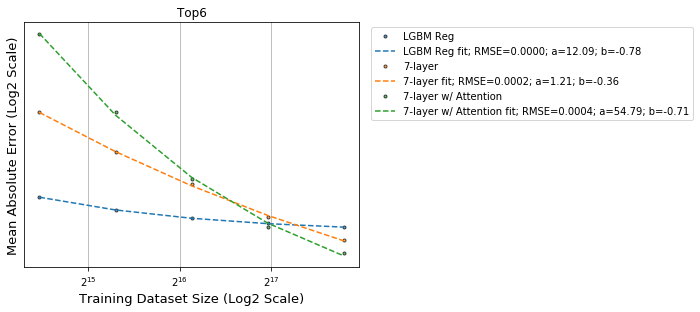

In [108]:
maindir = filepath / '../../pilot1/out/lrn_crv'
lgb_reg_dir       = maindir / '01_top6.lgb_reg.cvf5.rna.dsc.auc1_2019-6-20'
nn_model0_sgd_dir = maindir / '02_top6.nn_model0.sgd.cvf5.rna.dsc.auc1_2019-6-21'
nn_model1_sgd_dir = maindir / '03_top6.nn_model1.sgd.cvf5.rna.dsc.auc1_2019-6-22'

runs   = [lgb_reg_dir, nn_model0_sgd_dir, nn_model1_sgd_dir]
labels = ['LGBM Reg', '7-layer', '7-layer w/ Attention']

plot_kwargs = {'metric_name': 'mean_absolute_error', 'tr_set': False, 'cv_folds': 5, 'figsize': (6, 4.5), 'xtick_scale': 'log2', 'ytick_scale': 'log2', 'title': 'Top6'}
# plot_kwargs = {'metric_name': 'mean_absolute_error', 'tr_set': False, 'cv_folds': 5, 'figsize': (6, 4.5), 'xtick_scale': 'linear', 'ytick_scale': 'linear', 'title': 'Top6'}
shard_min_idx = 0

fit_pwr_multi_runs(runs=runs, labels=labels, **plot_kwargs, shard_min_idx=shard_min_idx)

# Recent Runs

In [26]:
def get_xy_(path, metric_name='mean_absolute_error', tr_set='te', shard_min_idx=0, cv_folds=1, ):
    scores = pd.read_csv(path/'lrn_crv_scores.csv') # load the scores file
    df = scores[scores['metric']==metric_name].reset_index(drop=True)     

    # tr, vl, te = df[df['set']=='tr'], df[df['set']=='vl'], df[df['set']=='te']
    # tr, vl, te = tr.iloc[:, -cv_folds:], vl.iloc[:, -cv_folds:], te.iloc[:, -cv_folds:]

    cols = ['tr_size'] + ['fold'+str(f+1) for f in range(cv_folds)]
    dd = df.loc[df['set']==tr_set, cols].sort_values('tr_size').reset_index(drop=True)

    x = dd.tr_size.values
    y = dd.iloc[:,1:].mean(axis=1).values # mean over folds        
    x, y = x[shard_min_idx:], y[shard_min_idx:]
    return x, y


def fit_pwr_multi_runs(runs, metric_name='mean_absolute_error', tr_set='te', cv_folds=1,
                       shard_min_idx=0, xtick_scale='log2', ytick_scale='log2'):
    prms = []
    for i, r in enumerate(runs):        
        x, y = get_xy_(path=r['dir'], metric_name=metric_name, cv_folds=cv_folds, tr_set=tr_set)
        
        if i == 0: ax = None
        ax, pwr_law_params = lrn_crv_plot.plot_lrn_crv_power_law(
            x=x, y=y,
            plot_fit=True, metric_name=metric_name,
            xtick_scale=ytick_scale, ytick_scale=ytick_scale,
            marker='.', alpha=0.7,
            label=r['name'], ax=ax, figsize=(8,6),
            title='Learning Curves')        
        
        prms.append( (r['name'], pwr_law_params) ) # aggregate params
    return prms

In [27]:
maindir = filepath / '../gdsc_trn/split_on_none'  # Results dir
# maindir = filepath / '../ctrp_trn/split_on_none'  # Results dir
# maindir = filepath / '../top6_trn/split_on_none'  # Results dir

# lgb_reg_auc_dir1 = maindir / 'gdsc.lgb_reg.cvf1.GE.DD.AUC_2019-11-4_h10-m18'
# lgb_reg_auc_dir2 = maindir / 'gdsc.lgb_reg.cvf1.GE.DD.AUC_2019-11-4_h10-m20'
# runs = [{'name': 'LGBM 100 trees',  'dir': lgb_reg_auc_dir1},
#         {'name': 'LGBM 1000 trees', 'dir': lgb_reg_auc_dir2}]

# rf_reg_auc_dir1 = maindir / 'gdsc.rf_reg.cvf1.GE.DD.AUC_2019-11-4_h10-m33'
# rf_reg_auc_dir2 = maindir / 'gdsc.rf_reg.cvf1.GE.DD.AUC_2019-11-4_h10-m48'
# runs = [{'name': 'RF 100 trees',  'dir': rf_reg_auc_dir1},
#         {'name': 'RF 1000 trees', 'dir': rf_reg_auc_dir2}]

lgb_reg_auc_dir2 = maindir / 'gdsc.lgb_reg.cvf1.GE.DD.AUC_2019-11-4_h10-m20'
rf_reg_auc_dir2 = maindir / 'gdsc.rf_reg.cvf1.GE.DD.AUC_2019-11-4_h10-m48'
nn_reg_auc_dir = maindir / 'gdsc.adam.nn_reg0.cvf1.GE.DD.AUC_2019-11-3_h14-m30'
nn_reg_auc_clr_dir = maindir / 'gdsc.sgd.trng1.nn_reg0.cvf1.GE.DD.AUC_2019-11-5_h15-m55'
runs = [{'name': 'LGBM 1000 trees', 'dir': lgb_reg_auc_dir2},
        {'name': 'RF 1000 trees', 'dir': rf_reg_auc_dir2},
        {'name': 'NN_REG0', 'dir': nn_reg_auc_dir},
        {'name': 'NN_REG0 clr', 'dir': nn_reg_auc_clr_dir}]

# nn_reg_auc_dir1 = maindir / 'gdsc.sgd.nn_reg0.cvf1.GE.DD.AUC_2019-11-3_h14-m35'
# nn_reg_auc_dir2 = maindir / 'gdsc.adam.nn_reg0.cvf1.GE.DD.AUC_2019-11-3_h14-m30'
# runs = [{'name': 'NN_REG0 SGD', 'dir': nn_reg_auc_dir1},
#         {'name': 'NN_REG0 ADAM', 'dir': nn_reg_auc_dir2}]

# lgb_reg_auc_dir = maindir / 'ctrp.lgb_reg.cvf1.GE.DD.AUC_2019-11-4_h16-m38'
# nn_reg_auc_dir = maindir / 'ctrp.sgd.nn_reg0.cvf1.GE.DD.AUC_2019-11-4_h13-m7'
# runs = [{'name': 'lgb_reg', 'dir': lgb_reg_auc_dir},
#         {'name': 'nn_reg0 sgd', 'dir': nn_reg_auc_dir}]

# nn_reg_auc_dir = maindir / 'top6.adam.nn_reg0.cvf1.GE.DD.AUC_2019-11-4_h14-m46'
# lgb_reg_auc_dir1 = maindir / 'top6.lgb_reg.cvf1.GE.DD.AUC_2019-11-4_h18-m10'
# lgb_reg_auc_dir2 = maindir / 'top6.lgb_reg.cvf1.GE.DD.AUC_2019-11-4_h18-m38'
# runs = [{'name': 'nn_reg',  'dir': nn_reg_auc_dir},
#         {'name': 'lgb_reg 100', 'dir': lgb_reg_auc_dir1},
#         {'name': 'lgb_reg 1000', 'dir': lgb_reg_auc_dir2}]

FileNotFoundError: [Errno 2] File b'/vol/ml/apartin/projects/LearningCurves/notebooks/../gdsc_trn/split_on_none/gdsc.adam.nn_reg0.cvf1.GE.DD.AUC_2019-11-3_h14-m30/lrn_crv_scores.csv' does not exist: b'/vol/ml/apartin/projects/LearningCurves/notebooks/../gdsc_trn/split_on_none/gdsc.adam.nn_reg0.cvf1.GE.DD.AUC_2019-11-3_h14-m30/lrn_crv_scores.csv'

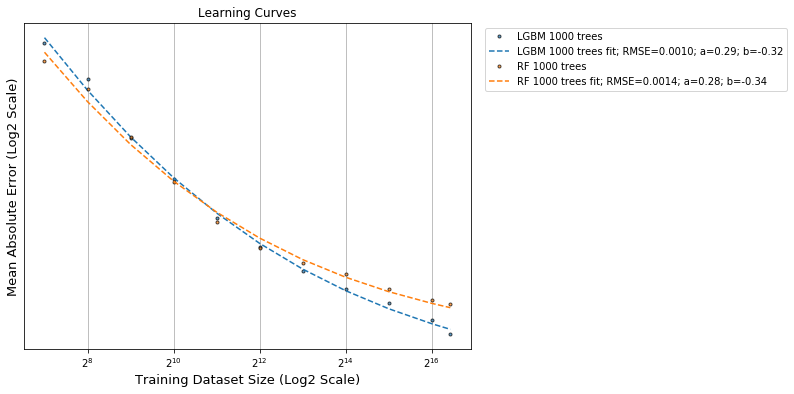

In [28]:
fit_pwr_multi_runs(runs, metric_name='mean_absolute_error', tr_set='te', shard_min_idx=4, cv_folds=1, xtick_scale='log2', ytick_scale='log2')